In [42]:
for f in sorted(Path("bustle_results_nodup").glob("run_*.attempt-1.300.grow-False.vw-bustle_sig-vsize.sygus.json")):
    print(f)

bustle_results_nodup/run_1.50000.attempt-1.300.grow-False.vw-bustle_sig-vsize.sygus.json
bustle_results_nodup/run_2.50000.attempt-1.300.grow-False.vw-bustle_sig-vsize.sygus.json
bustle_results_nodup/run_3.50000.attempt-1.300.grow-False.vw-bustle_sig-vsize.sygus.json
bustle_results_nodup/run_4.50000.attempt-1.300.grow-False.vw-bustle_sig-vsize.sygus.json
bustle_results_nodup/run_5.50000.attempt-1.300.grow-False.vw-bustle_sig-vsize.sygus.json


In [1]:
import glob
import json
import os
from pathlib import Path
from absl import app
from absl import flags
import re
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

MAX_PLOT_EXPS = 50 * 1000
MAX_PLOT_TIMES = 1 * 70

# Number of tasks in the benchmark sets.
NUM_NEW_TASKS = 38
NUM_SYGUS_TASKS = 89

# Title for each sub-plot.
NEW_TASKS_TITLE = "Successes by expression considered (38B)"
SYGUS_TITLE = "Successes by expression considered (SyGus)"

NEW_TASKS_TITLE2 = "Successes by time considered (38B)"
SYGUS_TITLE2 = "Successes by time considered (SyGus)"

# Directory to find CrossBeam results.
CROSSBEAM_DIR = "bustle_results_nodup"

# Names of datasets in results files.
NEW_TASKS_DATASET_NAME = "new"
SYGUS_DATASET_NAME = "sygus"

# Key -> (label, color, linestyle, linewidth).
# CrossBeam file formats -> (label, color, linestyle, linewidth, border_width)
CROSSBEAM_NOGROW_FORMATS = {
    "run_*.attempt-1.300.grow-False.vw-bustle_sig-vsize.{}.json": (
        "CrossBeam",
        "#028a0f",
        "-",
        2,
        1,
    ),  # green
    "run_*.attempt-2.300.grow-False.vw-bustle_sig-vsize.{}.json": (
        "CrossBeam 2",
        "#836fff",
        "-",
        2,
        1,
    ),  # green
    "run_*.attempt-4.300.grow-False.vw-bustle_sig-vsize.{}.json": (
        "CrossBeam 4",
        "#ff4500",
        "-",
        2,
        1,
    ),  # green
    "run_*.attempt-8.300.grow-False.vw-bustle_sig-vsize.{}.json": (
        "CrossBeam 8",
        "#338AFF",
        "-",
        2,
        1,
    ),  # green
    # "run_*.10.vw-bustle_sig-vsize.{}.json": ("CrossBeam 10", "#FC33FF", "-", 2, 1),  # green
}

CROSSBEAM_GROW_FORMATS = {
    "run_*.attempt-2.300.grow-True.vw-bustle_sig-vsize.{}.json": (
        "CrossBeam 2 grow",
        "#836fff",
        "-",
        2,
        1,
    ),
    "run_*.attempt-4.300.grow-True.vw-bustle_sig-vsize.{}.json": (
        "CrossBeam 4 grow",
        "#ff4500",
        "-",
        2,
        1,
    ),
    "run_*.attempt-8.300.grow-True.vw-bustle_sig-vsize.{}.json": (
        "CrossBeam 8 grow",
        "#338AFF",
        "-",
        2,
        1,
    ),
}

CROSSBEAM_TIME_FORMATS = {
    "run_*.attempt-86400.600.grow-False.vw-bustle_sig-vsize.{}.json": (
        "CrossBeam",
        "#028a0f",
        "-",
        2,
        1,
    ),  # green
    "run_*.attempt-2..600.grow-False.vw-bustle_sig-vsize.{}.json": (
        "CrossBeam 2",
        "#836fff",
        "-",
        2,
        1,
    ),  # green
    "run_*.attempt-4..600.grow-False.vw-bustle_sig-vsize.{}.json": (
        "CrossBeam 4",
        "#ff4500",
        "-",
        2,
        1,
    ),  # green
    "run_*.attempt-8.600.grow-False.vw-bustle_sig-vsize.{}.json": (
        "CrossBeam 8",
        "#338AFF",
        "-",
        2,
        1,
    ),  # green
}

In [91]:
# Space out nearby numbers on the right side of plots. Must change for new data.
EXPS_NUMBER_LABEL_TWEAKS = {
    33: 0.25,
    32: -0.25,
    75: 0.15,
    74: -0.15,
}


def get_number_label_delta(num_benchmarks):
    """Amount to move number labels downward to center them on the line."""
    return -1 * num_benchmarks / 110


def solve_text_y_position(solves, num_benchmarks):
    """The Y position to plot the number of solves as text."""
    return (
        solves
        + EXPS_NUMBER_LABEL_TWEAKS.get(solves, 0)
        + get_number_label_delta(num_benchmarks)
    )
    
def plot_expressions(
    title, num_benchmarks, crossbeam_dir, crossbeam_formats, dataset_name, add_legend=True
):
    """Plots benchmarks solved per expression considered."""
    xs = np.arange(0, MAX_PLOT_EXPS, 100)
    legend_handles = []

    # CrossBeam lines.
    for file_format, (
        label,
        color,
        linestyle,
        linewidth,
        border_width,
    ) in crossbeam_formats.items():
        all_runs = []
        files = sorted(Path(crossbeam_dir).glob(file_format.format(dataset_name)))
        print(file_format)
        print(len(files))
        for f in files:
            d = json.load(f.open("r"))
            solved_explored_data = []
            #solved_time_data = []
            results = d["results"]
            for i in range(len(results)):
                if results[i]["success"]:
                    attempt = results[i]["attempt"]
                    attempts_data = results[i - attempt + 1 : i + 1]
                    solved_explored_data.append(
                        sum(r["num_values_explored"] for r in attempts_data)
                    )
             #       solved_time_data.append(r["elapsed_time"] for r in attempts_data)
            ys = [np.sum(solved_explored_data <= x) for x in xs]
            all_runs.append(ys)
        all_runs = np.array(all_runs)
        all_runs_max = np.max(all_runs, axis=0)
        all_runs_min = np.min(all_runs, axis=0)
        all_runs_mean = np.mean(all_runs, axis=0)
        solves = max(all_runs_mean)
        solves = round(solves, 1)

        (line,) = plt.plot(
            xs,
            all_runs_mean,
            label=label,
            color=color,
            linestyle=linestyle,
            linewidth=linewidth,
        )
        if len(all_runs) > 1:
            fill = plt.fill_between(
                xs, all_runs_min, all_runs_max, facecolor=color, alpha=0.1
            )
            plt.plot(
                xs,
                all_runs_max,
                label=None,
                color=color,
                alpha=0.3,
                linestyle="-",
                linewidth=border_width,
            )
            plt.plot(
                xs,
                all_runs_min,
                label=None,
                color=color,
                alpha=0.3,
                linestyle="-",
                linewidth=border_width,
            )
            legend_handles.append((line, fill))
        else:
            assert solves == int(solves)
            solves = int(solves)
            legend_handles.append(line)

        plt.text(
            MAX_PLOT_EXPS * 1.005,
            solve_text_y_position(solves, num_benchmarks),
            solves,
            fontsize=9,
        )

    plt.xlim(0, MAX_PLOT_EXPS)
    plt.ylim(0, num_benchmarks)
    plt.title(title, fontsize=14)
    plt.xlabel("Number of Programs Evaluated", fontsize=12)
    plt.ylabel("Programs synthesized", fontsize=12)

    if add_legend:
        _, labels = plt.gca().get_legend_handles_labels()
        handles = legend_handles
        # Swap RobustFill and Baseline. We need to draw Baseline first so its solid
        # line doesn't cover DeepCoder, but let's have Baseline last in the legend.
        # Currently RobustFill is at position -1, Baseline at position -3.
        # handles[-1], handles[-3] = handles[-3], handles[-1]
        # labels[-1], labels[-3] = labels[-3], labels[-1]
        legend = plt.legend(handles, labels, loc="lower left", bbox_to_anchor=(1.04, 0))
        return legend
    else:
        return None

run_*.attempt-2.300.grow-True.vw-bustle_sig-vsize.{}.json
5
run_*.attempt-4.300.grow-True.vw-bustle_sig-vsize.{}.json
5
run_*.attempt-8.300.grow-True.vw-bustle_sig-vsize.{}.json
5
run_*.attempt-2.300.grow-True.vw-bustle_sig-vsize.{}.json
5
run_*.attempt-4.300.grow-True.vw-bustle_sig-vsize.{}.json
5
run_*.attempt-8.300.grow-True.vw-bustle_sig-vsize.{}.json
5
run_*.attempt-1.300.grow-False.vw-bustle_sig-vsize.{}.json
5
run_*.attempt-2.300.grow-False.vw-bustle_sig-vsize.{}.json
5
run_*.attempt-4.300.grow-False.vw-bustle_sig-vsize.{}.json
5
run_*.attempt-8.300.grow-False.vw-bustle_sig-vsize.{}.json
5
run_*.attempt-1.300.grow-False.vw-bustle_sig-vsize.{}.json
5
run_*.attempt-2.300.grow-False.vw-bustle_sig-vsize.{}.json
5
run_*.attempt-4.300.grow-False.vw-bustle_sig-vsize.{}.json
5
run_*.attempt-8.300.grow-False.vw-bustle_sig-vsize.{}.json
5


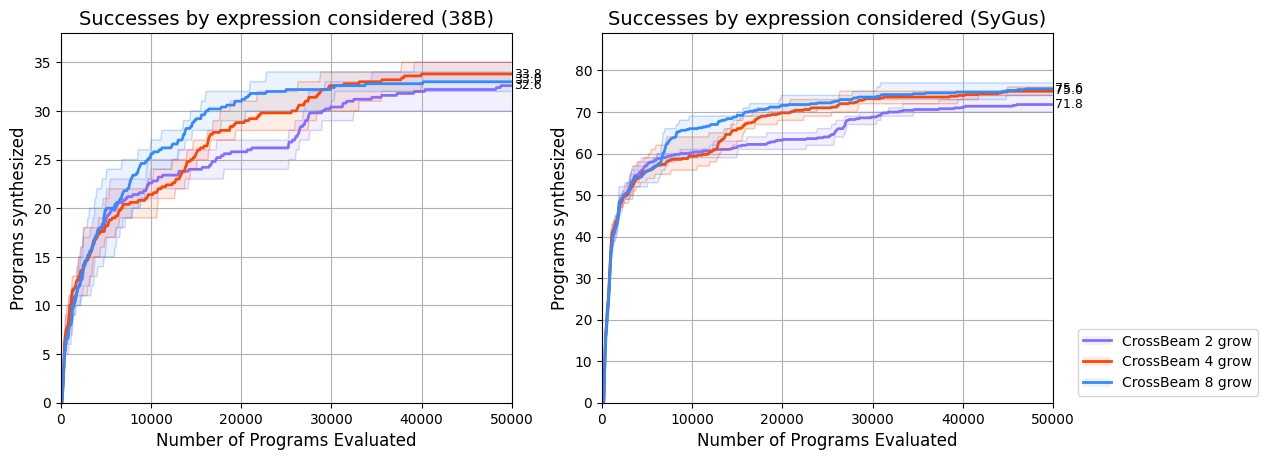

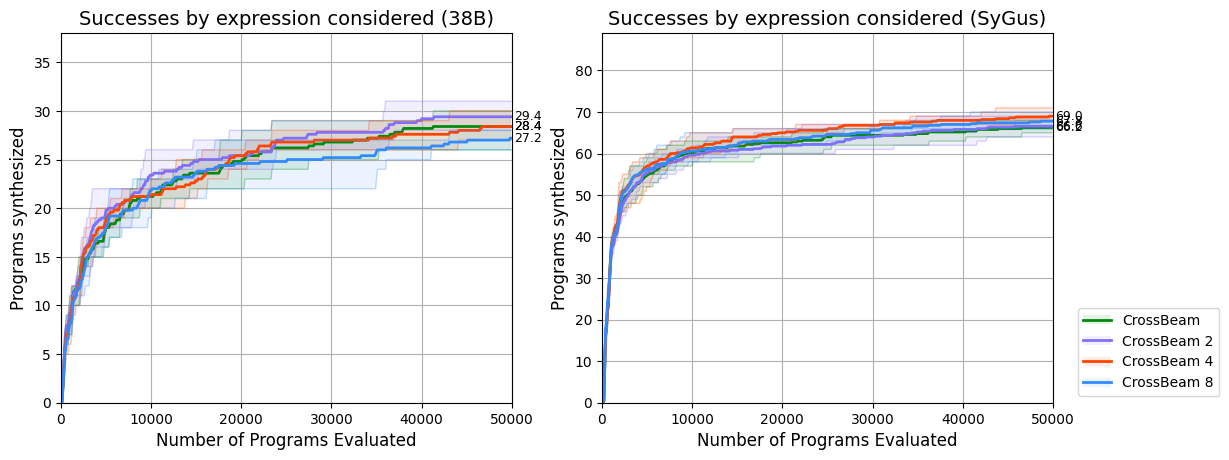

In [92]:
def plot():
    # sns.set()

    default_width = 6.4
    default_height = 4.8
    plt.figure(figsize=(default_width * 2, default_height))
    plt.subplot(121)
    plt.grid()
    plot_expressions(
        title=NEW_TASKS_TITLE,
        num_benchmarks=NUM_NEW_TASKS,
        crossbeam_dir=CROSSBEAM_DIR,
        crossbeam_formats=CROSSBEAM_GROW_FORMATS,
        dataset_name=NEW_TASKS_DATASET_NAME,
        add_legend=False,
    )
    plt.subplot(122)
    plt.grid()
    legend = plot_expressions(
        title=SYGUS_TITLE,
        num_benchmarks=NUM_SYGUS_TASKS,
        crossbeam_dir=CROSSBEAM_DIR,
        crossbeam_formats=CROSSBEAM_GROW_FORMATS,
        dataset_name=SYGUS_DATASET_NAME,
        add_legend=True,
    )
    
    plt.savefig(
        os.path.expanduser("grow_expressions.png"),
        bbox_inches="tight",
        bbox_extra_artists=[legend],
    )
    
    plt.figure(figsize=(default_width * 2, default_height))
    plt.subplot(121)
    plt.grid()
    plot_expressions(
        title=NEW_TASKS_TITLE,
        num_benchmarks=NUM_NEW_TASKS,
        crossbeam_dir=CROSSBEAM_DIR,
        crossbeam_formats=CROSSBEAM_NOGROW_FORMATS,
        dataset_name=NEW_TASKS_DATASET_NAME,
        add_legend=False,
    )
    plt.subplot(122)
    plt.grid()
    legend = plot_expressions(
        title=SYGUS_TITLE,
        num_benchmarks=NUM_SYGUS_TASKS,
        crossbeam_dir=CROSSBEAM_DIR,
        crossbeam_formats=CROSSBEAM_NOGROW_FORMATS,
        dataset_name=SYGUS_DATASET_NAME,
        add_legend=True,
    )
    plt.savefig(
        os.path.expanduser("nogrow_expressions.png"),
        bbox_inches="tight",
        bbox_extra_artists=[legend],
    )

plot()

In [5]:
exp_budget = 250000
dataset_name = "new"

dataset_dir="bustle_results_nodup"
format_string=f"run_{{}}.{exp_budget}.attempt-86400.600.grow-True.vw-bustle_sig-vsize.{{}}"
out_file = Path(dataset_dir) / f"failed600_{dataset_name}_{exp_budget}.txt"

failed_probs = {}
for run in range(1, 6):
    pth = Path(dataset_dir)
    assert (pth / format_string.format(run, f"{dataset_name}.json")).exists()
    p = pth / format_string.format(run, f"{dataset_name}_failed_tasks.txt")
    failed = []
    if p.exists():
        failed = [t for t in p.read_text().splitlines()]
    if failed:
        failed_probs[run] = failed
        
with out_file.open("w") as f:
    for run, failed in failed_probs.items():
        for prob in failed:
            f.write(f"{run} {prob}\n")

In [2]:
!ls bustle_results_nodup/

failed_new_250000.txt
failed_new_50000.txt
failed_sygus_250000.txt
failed_sygus_50000.txt
run_1.12500.attempt-4.300.grow-False.vw-bustle_sig-vsize.new_failed_tasks.txt
run_1.12500.attempt-4.300.grow-False.vw-bustle_sig-vsize.new.json
run_1.12500.attempt-4.300.grow-False.vw-bustle_sig-vsize.sygus_failed_tasks.txt
run_1.12500.attempt-4.300.grow-False.vw-bustle_sig-vsize.sygus.json
run_1.12500.attempt-4.300.grow-True.vw-bustle_sig-vsize.new_failed_tasks.txt
run_1.12500.attempt-4.300.grow-True.vw-bustle_sig-vsize.new.json
run_1.12500.attempt-4.300.grow-True.vw-bustle_sig-vsize.sygus_failed_tasks.txt
run_1.12500.attempt-4.300.grow-True.vw-bustle_sig-vsize.sygus.json
run_1.250000.attempt-86400.3600.grow-True.vw-bustle_sig-vsize.new.replaceAllCompany_failed_tasks.txt
run_1.250000.attempt-86400.3600.grow-True.vw-bustle_sig-vsize.new.replaceAllCompany.json
run_1.250000.attempt-86400.3600.grow-True.vw-bustle_sig-vsize.sygus.25239569.sl_failed_tasks.txt
run_1.250000.attempt-86400.3600.grow-True.v

In [6]:
exp_budget = 50000
dataset_name = "new"

dataset_dir="bustle_results_nodup"
format_string=f"run_{{}}.{exp_budget}.attempt-86400.21600.grow-True.vw-bustle_sig-vsize.{{}}"
out_file = Path(dataset_dir) / f"failed21600_{dataset_name}_{exp_budget}.txt"
failed_probs = {}
for run in range(1, 6):
    failed_probs[run] = []
    pth = Path(dataset_dir)
    glob_str = format_string.format(run, f"{dataset_name}*_failed_tasks.txt")
    for fpth in pth.glob(glob_str):
        print(fpth)
        failed_probs[run].extend([t for t in fpth.read_text().splitlines()])
        
with out_file.open("w") as f:
   for run, failed in failed_probs.items():
       for prob in failed:
            f.write(f"{run} {prob}\n")